In [1]:
from __future__ import print_function

# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import pickle, numpy as np
from random import Random
from helpers import *


Using TensorFlow backend.


In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =10000 # Number of samples to train on.
# Path to the datatxt file on disk.
data_path = 'fra.txt'


In [12]:
all_input_phrases, all_target_phrases = read_data(data_path)
# do some text pre-processing
all_input_phrases = text_preprocess(all_input_phrases)
all_target_phrases = text_preprocess(all_target_phrases)
# add the delimiters signifying the beginning and end of a sequence
all_target_phrases = wrap_with_delims(all_target_phrases)

# keep only `num_samples` examples. 
# Note: we're starting from the 2nd example, its not important
input_phrases, target_phrases = all_input_phrases[:num_samples], all_target_phrases[:num_samples]
# Wrap the target phrases with delimiters signifying the start end end of the sequence

print("Training on %d selected phrases" % len(input_phrases))

Training on 10000 selected phrases


In [13]:
list(zip(input_phrases[:5], target_phrases[:5]))

[('go', '\tva !\n'),
 ('run!', '\tcours!\n'),
 ('run!', '\tcourez!\n'),
 ('fire!', '\tau feu !\n'),
 ('help!', "\tà l'aide!\n")]

In [14]:
# build the token index on all available phrases
input_token_index = token_index(all_input_phrases)
target_token_index = token_index(all_target_phrases)
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
max_encoder_seq_length = max([len(txt) for txt in input_phrases])
max_decoder_seq_length = max([len(txt) for txt in target_phrases])
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of unique input tokens: 63
Number of unique output tokens: 83
Max sequence length for inputs: 16
Max sequence length for outputs: 58


In [7]:
def models(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')
    encoder = LSTM(latent_dim, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', 
                          name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Next: inference mode (sampling).
    # Here's the drill:
    # 1) encode input and retrieve initial decoder state
    # 2) run one step of decoder with this initial state
    # and a "start of sequence" token as target.
    # Output will be the next target token
    # 3) Repeat with the current target token and current states

    # Define sampling models
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_input_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model


In [8]:
model, encoder_model, decoder_model = models(num_encoder_tokens, num_decoder_tokens, latent_dim)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [15]:
X, Y = vectorize_dataset(input_phrases, target_phrases,
                  input_token_index,target_token_index,
                  max_encoder_seq_length, max_decoder_seq_length)
history = model.fit(X,Y,
                   batch_size=batch_size, epochs=epochs, 
                   validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.8979 - val_loss: 0.9907
Epoch 2/100
9000/9000 [==============================] - 20s 2ms/step - loss: 0.7376 - val_loss: 0.8269
Epoch 3/100
9000/9000 [==============================] - 19s 2ms/step - loss: 0.6355 - val_loss: 0.7563
Epoch 4/100
9000/9000 [==============================] - 19s 2ms/step - loss: 0.5784 - val_loss: 0.7149
Epoch 5/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.5397 - val_loss: 0.6668
Epoch 6/100
9000/9000 [==============================] - 20s 2ms/step - loss: 0.5049 - val_loss: 0.6502
Epoch 7/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.4766 - val_loss: 0.6151
Epoch 8/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.4528 - val_loss: 0.5963
Epoch 9/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.4319 - val_loss: 0.5801
Epoch 10/100
900

9000/9000 [==============================] - 17s 2ms/step - loss: 0.0821 - val_loss: 0.7486
Epoch 79/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0808 - val_loss: 0.7562
Epoch 80/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0795 - val_loss: 0.7548
Epoch 81/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0783 - val_loss: 0.7615
Epoch 82/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0770 - val_loss: 0.7656
Epoch 83/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0761 - val_loss: 0.7695
Epoch 84/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0747 - val_loss: 0.7805
Epoch 85/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0734 - val_loss: 0.7839
Epoch 86/100
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0721 - val_loss: 0.7840
Epoch 87/100
9000/9000 [==============================] - 17s 2ms/st

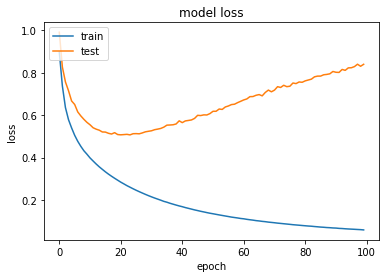

In [16]:
plot_history(history)

In [17]:
test_input_phrases = all_input_phrases[num_samples:num_samples+1000]
test_target_phrases = all_target_phrases[num_samples:num_samples+1000]

X, Y = vectorizer(test_input_phrases, test_target_phrases)
model.evaluate(X, Y)

NameError: name 'vectorizer' is not defined

In [ ]:
model.save('training.h5')
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')

model_metadata = { 'input_token_index': input_token_index, 
                   'target_token_index': target_token_index,
                   'max_encoder_seq_length': max_encoder_seq_length }

with open('model_metadata.pickle', 'wb') as f:
    pickle.dump(model_metadata, f)

In [ ]:
model = load_model('training.h5')
encoder_model = load_model('encoder.h5')
decoder_model = load_model('decoder.h5')

with open('model_metadata.pickle', 'rb') as f:
    model_metadata = pickle.load(f)

input_token_index = model_metadata['input_token_index']
target_token_index = model_metadata['target_token_index']
max_encoder_seq_length = model_metadata['max_encoder_seq_length']

In [15]:
model.evaluate([encoder_input_data, decoder_input_data], 
                   decoder_target_data,)

 17376/280000 [>.............................] - ETA: 9:44

KeyboardInterrupt: 

In [18]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = {v: k for k, v in input_token_index.items()}
reverse_target_char_index = {v: k for k, v in target_token_index.items()} 

In [19]:
[l.name for l in decoder_model.layers]

['decoder_inputs',
 'decoder_input_h',
 'decoder_input_c',
 'decoder_lstm',
 'decoder_dense']

In [20]:
input_phrases[:25]

['go',
 'run!',
 'run!',
 'fire!',
 'help!',
 'jump',
 'stop!',
 'stop!',
 'stop!',
 'wait!',
 'wait!',
 'go on',
 'go on',
 'go on',
 'i see',
 'i try',
 'i won!',
 'i won!',
 'oh no!',
 'attack!',
 'attack!',
 'cheers!',
 'cheers!',
 'cheers!',
 'cheers!']

In [21]:
def translate(phrase, encoder_model, decoder_model, 
              input_token_index, target_token_index):
    vect = vectorize_phrase(phrase, input_token_index,
                            max_encoder_seq_length)
    decoded = decode_sequence(vect,target_token_index, 
                        encoder_model, decoder_model)
    return decoded[:-1]

translator = lambda p: translate(p, encoder_model, decoder_model,
                                input_token_index, target_token_index)

'va !'

In [12]:
input_phrases, _ = read_data(data_path)
input_phrases = text_preprocess(input_phrases)

encoder_vectorizer = lambda b: vectorize_batch(b, input_token_index,
                                               max_encoder_seq_length)
decoder_vectorizer = lambda b, offset: vectorize_batch(b, target_token_index,
                                                       max_decoder_seq_length, offset) 

def vectorized_gen(phrases, batch_size,encoder_vectorizer, decoder_vectorizer):
    for i in range(0, len(phrases), batch_size):
        input_phrases, target_phrases =  misspelling_gen(phrases[i:i+batch_size], 0.07, 3)
        print(len(input_phrases))
        print(len(target_phrases))
        encoder_input_data = encoder_vectorizer(input_phrases)
        decoder_input_data = decoder_vectorizer(target_phrases, False)
        decoder_target_data = decoder_vectorizer(target_phrases, True)
        max_encoder_seq_length = max([len(txt) for txt in input_phrases])
        
        yield ([encoder_input_data, decoder_input_data], decoder_target_data)
        print('yielded')

training_generator = vectorized_gen(input_phrases, num_samples, encoder_vectorizer, decoder_vectorizer)


In [14]:
input_token_index = token_index(input_phrases)
target_token_index = token_index(target_phrases)
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
max_encoder_seq_length = max([len(txt) for txt in input_phrases])
max_decoder_seq_length = max([len(txt) for txt in target_phrases])

In [15]:
for _ in range(5):
    spell_gen = lambda : misspelling_gen(input_phrases, 0.07, 3)
    X, Y = next(training_generator)
    model.fit(X, Y,
          batch_size=batch_size,
          epochs=5,
          validation_split=0.1)


240000
240000


MemoryError: 